# Implementar o DCGAN no MNIST dataset

In [1]:
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch import nn
from  torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.distributions import Multinomial
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import os
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
dataroot = "/home/ninja/MNIST/training/"        # Root directory for dataset
workers = 6                    # Number of workers for dataloader
batch_size = 256
image_size = 64
ngpu = 1                       # Number of GPUs available. Use 0 for CPU mode.

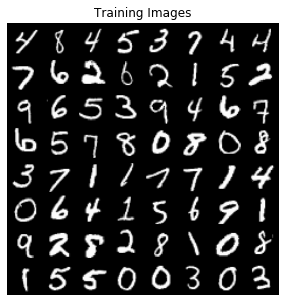

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # usar apenas se tiver mais de um canal
                           ]))
# Create the dataloader
dataloader = Data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

---
* Funções de auxílio

In [4]:
def plot_losses(losses_his):
    plt.figure(figsize=(20,8))
    plt.subplot(331)
    plt.plot(losses_his[0])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador')
    plt.subplot(332)
    plt.plot(losses_his[1])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador')
    plt.subplot(333)
    plt.plot(losses_his[2])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Q')
    plt.subplot(334)
    plt.plot(losses_his[3])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Real')
    plt.subplot(335)
    plt.plot(losses_his[4])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Falso 1')
    plt.subplot(336)
    plt.plot(losses_his[5])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Falso 2')    
#     plt.subplot(337)
#     plt.plot(losses_his[6])
#     plt.grid(True)
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss: Q discrete')
#     plt.subplot(338)
#     plt.plot(losses_his[7])
#     plt.grid(True)
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss: Q continuous')
#     plt.savefig('images/losses_plot',quality=100)
    plt.show()

def plot_from_latent(c):
    c1,c2,c3,c4 = c
    fake1 = get_X_from_c(label=c1, n_sample=64)
    fake2 = get_X_from_c(label=c2, n_sample=64)
    fake3 = get_X_from_c(label=c3, n_sample=64)
    fake4 = get_X_from_c(label=c4, n_sample=64)
    plt.figure(figsize=(20,5))
    plt.subplot(1,4,1)
    plt.axis("off")
    plt.title(f"Fake Images: c={c1}")
    plt.imshow(np.transpose(vutils.make_grid(fake1[:64], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.subplot(1,4,2)
    plt.axis("off")
    plt.title(f"Fake Images: c={c2}")
    plt.imshow(np.transpose(vutils.make_grid(fake2[:64], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.subplot(1,4,3)
    plt.axis("off")
    plt.title(f"Fake Images: c={c3}")
    plt.imshow(np.transpose(vutils.make_grid(fake3[:64], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.subplot(1,4,4)
    plt.axis("off")
    plt.title(f"Fake Images: c={c4}")
    plt.imshow(np.transpose(vutils.make_grid(fake4[:64], padding=5, normalize=True).cpu(),(1,2,0)))    
    plt.show()
    
def plot_digit(x):
    x = x.data.numpy().reshape(data1.shape[1],data1.shape[2])
    plt.imshow(x,cmap='gray_r')
    plt.show()
    
def plot_n_random_digits(x,labels=None,n_images=9,title='gan_random_digits'):
    """Ate 20 imagens"""
    indices = np.random.choice(x.shape[0],size=n_images)
    x = x[indices].data.numpy()
    if isinstance(labels, torch.IntTensor):
        sample_labels = labels[indices].data.numpy()
    else: sample_labels = ['None']*len(indices)
    x = x.reshape(n_images,data1.shape[1],data1.shape[2])
    plt.clf()
    plt.style.use('seaborn-muted')
    fig, axes = plt.subplots(2,10, figsize=(15,3), sharex=True, sharey=True,
                             subplot_kw=dict(adjustable='box', aspect='equal'))
    for i in range(n_images):
        subplot_row = i//10
        subplot_col = i%10  
        ax = axes[subplot_row, subplot_col]
        plottable_image = x[i,:]
        ax.imshow(plottable_image, cmap='gray_r')
        ax.set_title('Digit Label: {}'.format(sample_labels[i]))
        ax.set_xbound([0,28])
    plt.tight_layout()
#     plt.savefig('images/'+title+'.png',quality=100)
    plt.show()

def print_label(label):
    chosen_label = label
    batch = 1000
    y_sample = np.zeros(shape=[batch, y_dim])
    y_sample[:,chosen_label] = 1
    y_sample_tc = torch.Tensor(y_sample).type(torch.IntTensor)
    plot_n_random_digits(G(Variable(torch.randn(batch, Z_dim)).cuda(),
                         y_sample_tc.type(torch.FloatTensor).cuda()).cpu(),
                         labels=torch.max(y_sample_tc,dim=1)[1].type(torch.IntTensor),
                         n_images=20,title='conditional_gan_generated_{}_{}_'.format(chosen_label,epochs))

def choose_c(label,batch):
    chosen_label = label
    batch = batch
    a = np.zeros(shape=[batch, 10])
    a[:,chosen_label] = 1
    return torch.Tensor(a).type(torch.FloatTensor)

def get_X_from_c(label,n_sample):
    z = noise(n_sample, nz)
    c = choose_c(label,n_sample).reshape(n_sample,nu,1,1).to(device)
    return G(z,c).detach().cpu()

def get_X_from_w(label,n_sample):
    z = noise(n_sample, nz)
    c = noise_discrete(n_sample,nu)
    w = torch.full((n_sample,), label, device=device).reshape(n_sample,1,1,1)
    return G(z,c,w).detach().cpu()

def get_X_from_c_w(label_c,label_w,n_sample):
    z = noise(n_sample, nz)
    c = choose_c(label_c,n_sample).reshape(n_sample,nu,1,1).to(device)
    w = torch.full((n_sample,), label_w, device=device).reshape(n_sample,1,1,1)
    return G(z,c,w).detach().cpu()
    
def G_reality_test(n_sample,G,D,nz,nu):
    z,c = noises(n_sample,nz,nu)
    x_out = D(G(z,c))
    D_fake = Dh(x_out)
    D_fake = D_fake.view(-1)
    print('Average D_fake  {:.6f}| Std D_fake  {:.6f}'.format(D_fake.mean(),D_fake.std()))
    
def check_c_w_errors(n_sample,G,D,nz,nu):
    z,c,w = noises(n_sample,nz,nu)
    _, c_exp, mu_exp, var_exp = D(G(z,c,w))
    gauss = gaussian_sample(mu_exp,var_exp,n_sample)
    rmse = RMSELoss(gauss,w.reshape(n_sample,1)).item()
    acc = (torch.max(c_exp.reshape(n_sample,nu),dim=1)[1] == torch.max(c.reshape(n_sample,nu),dim=1)[1]).sum().item()/n_sample
    print('Q c accuracy  {:.2f}%'.format(acc*100))
    print('Q w mean sq   {:.2f}'.format(rmse))

def check_c_error(n_sample,G,D,nz,nu):
    z,c= noises(n_sample,nz,nu)
    x_out = D(G(z,c))
    c_exp = Q(x_out)
    acc = (torch.max(c_exp.reshape(n_sample,nu),dim=1)[1] == torch.max(c.reshape(n_sample,nu),dim=1)[1]).sum().item()/n_sample
    print('Q c accuracy  {:.2f}%'.format(acc*100))
    
def noise(dim0,dim1):
    return torch.randn(dim0, dim1, 1, 1, device=device)

def noise_discrete(dim0,dim1):
    c = Multinomial(probs=torch.Tensor([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]))\
    .sample(sample_shape=torch.Size([dim0,1,1]))\
    .reshape(dim0,dim1,1,1).to(device)
    return c

def noise_uniform(dim0):
    c = Uniform(torch.tensor([-1.0]), torch.tensor([1.0]))\
    .sample(sample_shape=torch.Size([dim0,1,1])).to(device)
    return c

def noises(X_size,nz,nu):
    z = noise(X_size,nz)
    c = noise_discrete(X_size,nu)
    return z,c

---

![](images/dcgan_generator.png)

In [5]:
nc, nw, nu, nz, ngf, ndf = [1,1,10,62,64,64]
# Generator
class GNet(torch.nn.Module):
    def __init__(self, ngpu):
        super(GNet, self).__init__()
        self.ngpu = ngpu
        self.conv1 = torch.nn.ConvTranspose2d( nz + nu, ngf * 8, 4, 1, 0, bias=False)
        self.conv2 = torch.nn.BatchNorm2d(ngf * 8)
        self.conv3  = torch.nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.conv4  = torch.nn.BatchNorm2d(ngf * 4)
        self.conv5  = torch.nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.conv6  = torch.nn.BatchNorm2d(ngf * 2)
        self.conv7  = torch.nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False)
        self.conv8  = torch.nn.BatchNorm2d(ngf)
        self.conv9  = torch.nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False)

    def forward(self, z,c):
        h = self.conv1(torch.cat((z,c),dim=1))
        h = F.relu(self.conv2(h))
        h = self.conv3(h)
        h = F.relu(self.conv4(h))
        h = self.conv5(h)
        h = F.relu(self.conv6(h))
        h = self.conv7(h)
        h = self.conv8(h)
        h = torch.sigmoid(self.conv9(h))
        return h

# Discriminator
class DNet(torch.nn.Module):
    def __init__(self, ngpu):
        super(DNet, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 8),
            torch.nn.LeakyReLU(0.2, inplace=True))
#         self.conv_out = torch.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)

    def forward(self, x):
        x_out = self.main(x)
        return x_out

class Dhead(torch.nn.Module):
    def __init__(self, ngpu):
        super(Dhead, self).__init__()
        self.ngpu = ngpu
        self.conv1 = torch.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)

    def forward(self, x_out):
        h = torch.sigmoid(self.conv1(x_out))
        return h

class Qhead(torch.nn.Module):
    def __init__(self, ngpu):
        super(Qhead, self).__init__()
        self.ngpu = ngpu
#         self.conv1 = torch.nn.Conv2d(ndf * 8, 10, 4, 1, 0, bias=False)
        self.flat = nn.modules.Flatten()
        self.linear1 = torch.nn.Linear(8192, 100)
        self.linear2 = torch.nn.Linear(100, 10)
        
    def forward(self, d_out):
#         c = self.conv1(d_out)
        c = self.flat(d_out)
        c = self.linear1(c)
        c = torch.softmax(self.linear2(c), dim=1)
        return c


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
G = GNet(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, list(range(ngpu)))
G.apply(weights_init)
D = DNet(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    D = nn.DataParallel(D, list(range(ngpu)))
D.apply(weights_init)
Dh = Dhead(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    Dh = nn.DataParallel(Dh, list(range(ngpu)))
Dh.apply(weights_init)
Q = Qhead(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    Q = nn.DataParallel(Q, list(range(ngpu)))
Q.apply(weights_init)

lrd,lrg = [2e-4,1e-3]                   
beta = 0.5                   
# Definimos os otimizadores
G_optim  = optim.Adam(G.parameters(),  lr=lrg, betas=(beta,0.999))
D_optim  = optim.Adam([{'params':Dh.parameters()}, {'params':D.parameters()}],  lr=lrd, betas=(beta,0.999))
Q_optim  = optim.Adam(Q.parameters(),  lr=lrg, betas=(beta,0.999))


def Q_loss_func(c_expected, c):
    return torch.mean(-torch.sum(c * torch.log(c_expected + 1e-8), dim=1)) + 2.3

def reset_grad():
    G_optim.zero_grad()
    D_optim.zero_grad()

loss = torch.nn.BCELoss()
loss_logits = nn.BCEWithLogitsLoss()
l2_loss = torch.nn.MSELoss()

def RMSELoss(x_fake,x_real):
    return torch.sqrt(torch.mean((x_fake-x_real)**2))

def gaussian_sample(mu_expected,var_expected, dim):
    return Normal(mu_expected.reshape(dim,1),var_expected.reshape(dim,1)).sample()

real_label = 1
fake_label = 0

fixed_z,fixed_c = noises(X_size=image_size,nz=nz,nu=nu)

G_his, D_his, D_real_his, D_fake1_his, D_fake2_his, Q_dis_his, Q_con_his, Q_his = [[],[],[],[],[],[],[],[]]
losses_his = [G_his,D_his,Q_his,D_real_his,D_fake1_his, D_fake2_his, Q_dis_his, Q_con_his]
img_list = []

In [6]:
#load saved networks
# G.load_state_dict(torch.load('models/g_infocgan_mnist.pt'))
# D.load_state_dict(torch.load('models/d_infocgan_mnist.pt'))
# Q.load_state_dict(torch.load('models/q_infocgan_mnist.pt'))

Starting Training Loop...
Epoch-1: 234/235 | Av. D_loss:  0.257 | Av. G_loss: 7.971
D real:  0.963 | D_fake_1:    0.185 | D_fake_2: 0.005
Q loss: 2.303730010986328
Average D_fake  0.003193| Std D_fake  0.003043
Q c accuracy  99.30%


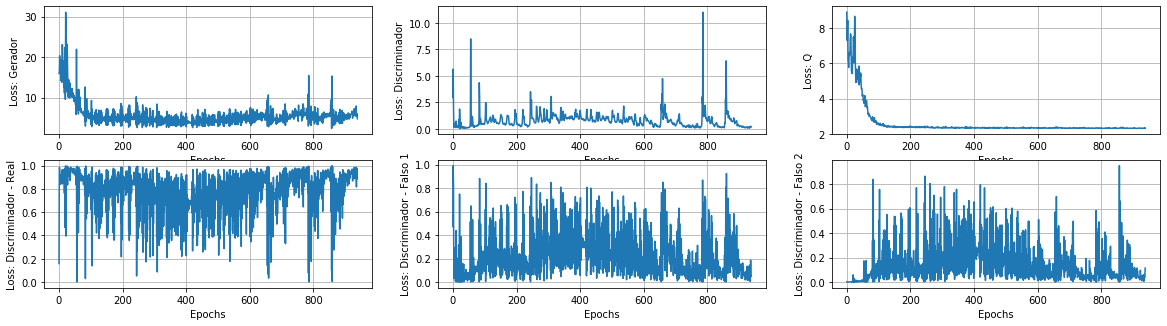

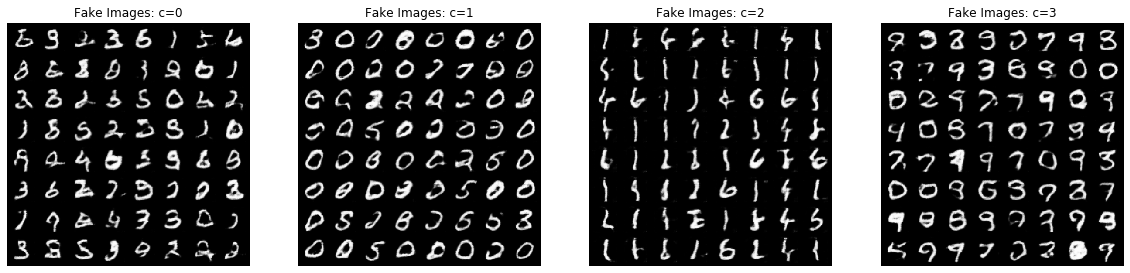

--------------------------------------------------------------------------------
Epoch-2: 234/235 | Av. D_loss:  0.606 | Av. G_loss: 5.511
D real:  0.866 | D_fake_1:    0.344 | D_fake_2: 0.056
Q loss: 2.329087257385254
Average D_fake  0.084130| Std D_fake  0.077830
Q c accuracy  99.00%


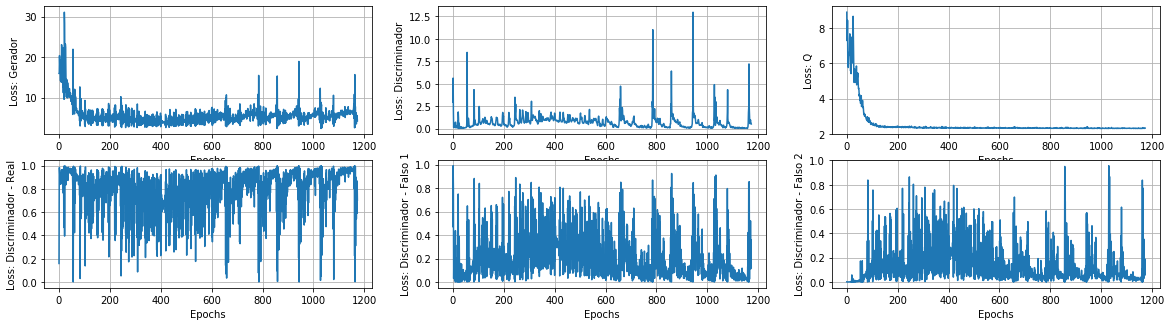

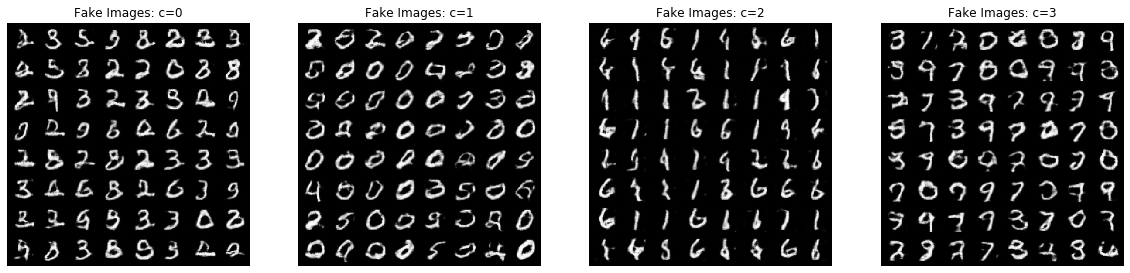

--------------------------------------------------------------------------------
Epoch-3: 234/235 | Av. D_loss:  0.375 | Av. G_loss: 4.603
D real:  0.805 | D_fake_1:    0.118 | D_fake_2: 0.122
Q loss: 2.300645351409912
Average D_fake  0.244247| Std D_fake  0.136876
Q c accuracy  99.80%


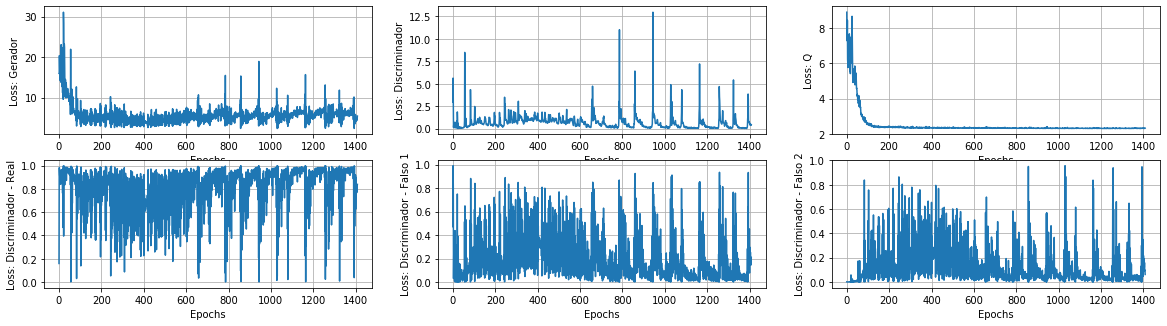

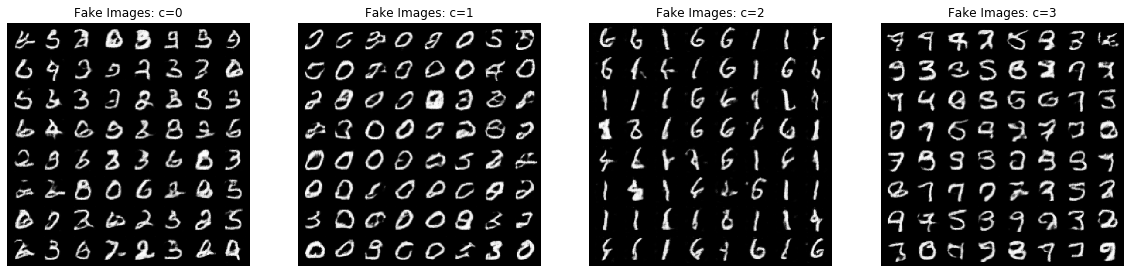

--------------------------------------------------------------------------------
CPU times: user 5min 46s, sys: 1.04 s, total: 5min 47s
Wall time: 5min 45s


In [14]:
%%time
iters = 0
num_epochs = 3

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        X_real = data[0].to(device)
        X_size = X_real.size(0)
        ones = torch.full((X_size,), real_label, device=device)
        zeros = torch.full((X_size,), fake_label, device=device)
        
        z,c = noises(X_size,nz,nu)
        X_fake = G(z,c)
        
        x_out = D(X_real)
        X_real_out = Dh(x_out)
        X_real_out  = X_real_out.view(-1)

        D_loss_real = loss(X_real_out, ones)
        D_loss_real_mean = X_real_out.mean().item()
        x_out = D(X_fake)
        X_fake_out = Dh(x_out)
        X_fake_out = X_fake_out.view(-1)
#         c_exp = Q(d_out.detach())
#         Q_loss = Q_loss_func(c_exp.reshape(X_size,nu),c.reshape(X_size,nu))
        D_loss_fake = loss(X_fake_out, zeros)
        D_loss_fake_mean_1 = X_fake_out.mean().item()
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward(retain_graph=True)
        D_optim.step()
        
        c_exp = Q(x_out)
        Q_loss = Q_loss_func(c_exp.reshape(X_size,nu),c.reshape(X_size,nu))
        Q_loss.backward()
        Q_optim.step()
        D_optim.zero_grad()
        Q_optim.zero_grad()
        G_optim.zero_grad()
    
        
        z,c = noises(X_size,nz,nu)
        X_fake = G(z,c)
        x_out = D(X_fake)
        X_fake_out = Dh(x_out)
        X_fake_out = X_fake_out.view(-1)
        c_exp = Q(x_out)
        Q_loss = Q_loss_func(c_exp.reshape(X_size,nu),c.reshape(X_size,nu))
        G_loss = loss(X_fake_out, ones) + Q_loss
        G_loss.backward()
        D_loss_fake_mean_2 = X_fake_out.mean().item()
        G_optim.step()
        D_optim.zero_grad()
        Q_optim.zero_grad()
        G_optim.zero_grad()
        

        if i == 234:
            print('Epoch-{}: {}/{} | Av. D_loss:  {:.3f} | Av. G_loss: {:.3f}'.format(
                epoch+1,i, len(dataloader), D_loss.item(), G_loss.item()))
            print('D real:  {:.3f} | D_fake_1:    {:.3f} | D_fake_2: {:.3f}'.format(
            D_loss_real_mean, D_loss_fake_mean_1,D_loss_fake_mean_2))
            print('Q loss:',Q_loss.item())
#             print('Q loss:  {:.3f} | Q loss disc: {:.3f} | Q loss cont: {:.3f}'.format(
#                 Q_loss.item(),Q_loss_discrete.item(),Q_loss_continuous.item()))
            G_reality_test(200,G,D,nz,nu)
            check_c_error(1000,G,D,nz,nu)
            plot_losses(losses_his)
            plot_from_latent(c=[0,1,2,3])
            print('-'*80)

        G_his.append(G_loss.item())
        D_his.append(D_loss.item())
        D_real_his.append(D_loss_real_mean)
        D_fake1_his.append(D_loss_fake_mean_1)
        D_fake2_his.append(D_loss_fake_mean_2)
#         Q_dis_his.append(Q_loss_discrete.item())
#         Q_con_his.append(Q_loss_continuous.item())
        Q_his.append(Q_loss.item())
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_z,fixed_c).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Average D_fake  0.188069| Std D_fake  0.122341
Q c accuracy  99.80%


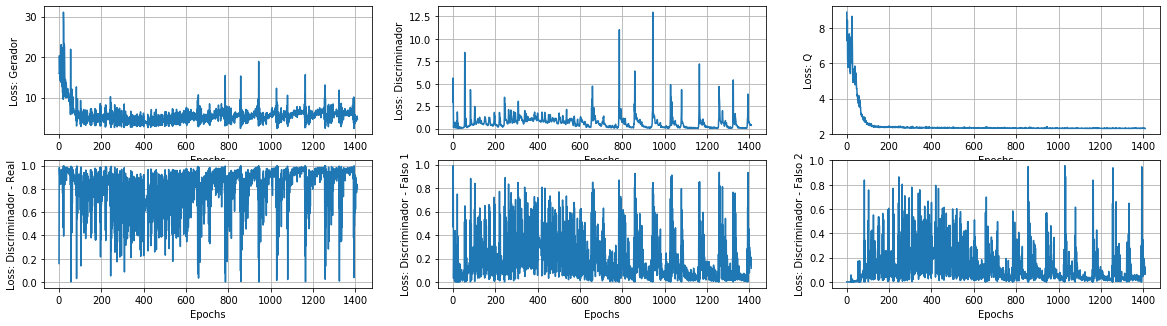

In [15]:
G_reality_test(200,G,D,nz,nu)
check_c_error(1000,G,D,nz,nu)
plot_losses(losses_his)

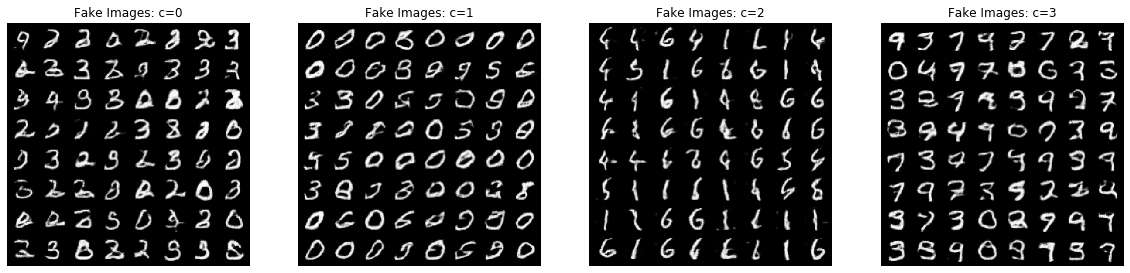

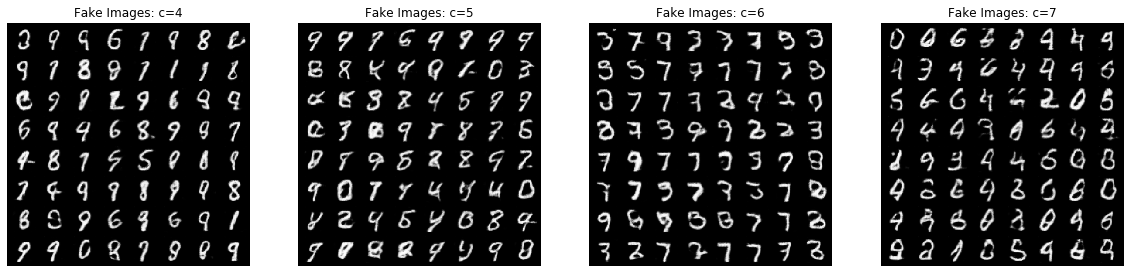

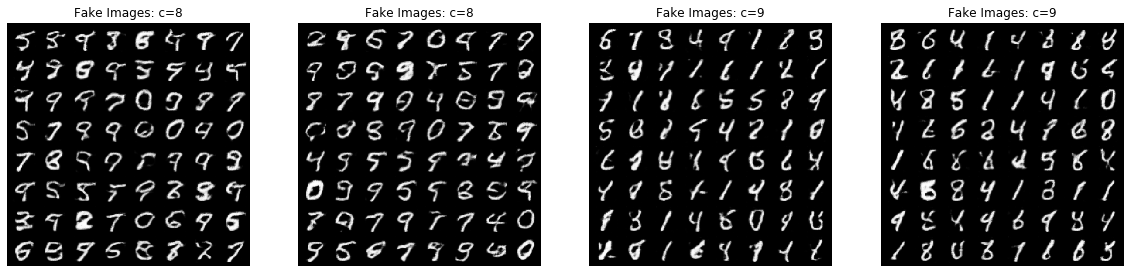

In [16]:
plot_from_latent(c=[0,1,2,3])
plot_from_latent(c=[4,5,6,7])
plot_from_latent(c=[8,8,9,9])

In [132]:
# #save networks
torch.save(G.state_dict(), 'models/g_infodcgan_mnist_original_20k.pt')
torch.save(D.state_dict(), 'models/d_infodcgan_mnist_original_20k.pt')

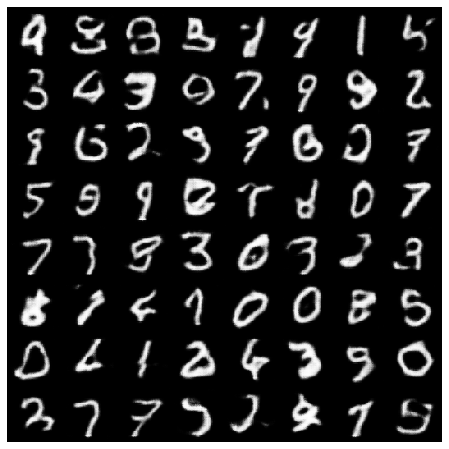

In [13]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

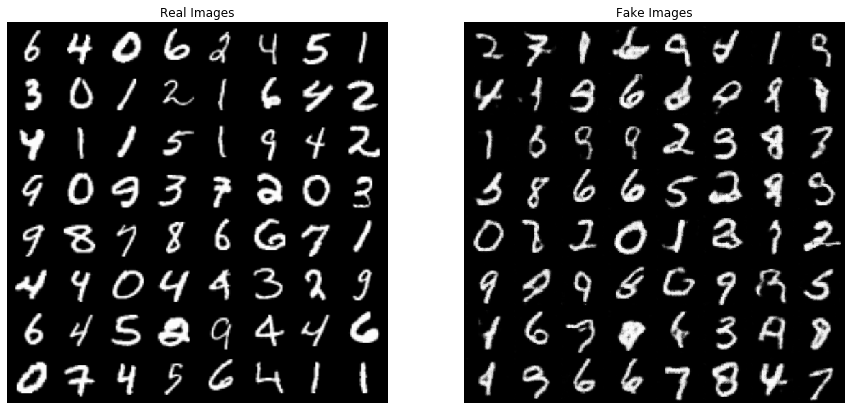

In [134]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()